Name: GUK IL KIM 
<br>
Github Username: DanielKim12
<br>
USC ID: 3020867072

Import packages

In [5]:
import tensorflow as tf
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16
from tensorflow.keras import Sequential, layers, optimizers, callbacks, regularizers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
# from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
import os
import matplotlib.pyplot as plt
from keras import mixed_precision
from sklearn.metrics import classification_report, roc_auc_score
from IPython.display import clear_output 
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")
tf.keras.backend.clear_session()

# Suppress TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [6]:
mixed_precision.set_global_policy('mixed_float16') #req was mentioned on piazza

In [7]:
train_dir = "../input/test-train/data/seg_train"
test_dir =  "../input/test-train/data/seg_test"

In [8]:
IMG_SIZE = (224, 224)  # Resize images to 224x224
BATCH_SIZE = 64       # Number of images per batch, setting it high

# 80% train set
train_dataset = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,   
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# 20% validation
validation_dataset = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# keep the same
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

print("Class names:", train_dataset.class_names)

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),  # Rotation up to 20 degrees
    layers.RandomZoom(0.1),      # Zoom up to 10%
    layers.RandomContrast(0.1)   # Mild contrast adjustment
])

# Preprocess Training Data (Augmentation + Normalization to [-1, 1]), 
# was mentioned on piazza that scaling to [-1,1] works better than [0,1]
def preprocess_train(image, label):
    image = tf.cast(image, tf.float32) / 127.5 - 1  # Scale to [-1, 1]
    image = data_augmentation(image)               # Apply augmentations
    return image, label

# Preprocess Validation and Test Data (Normalization only)
def preprocess_eval(image, label):
    image = tf.cast(image, tf.float32) / 127.5 - 1  # Scale to [-1, 1]
    return image, label

# Apply preprocessing to datasets
train_dataset = train_dataset.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess_eval, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_eval, num_parallel_calls=tf.data.AUTOTUNE)

# Prefetching for performance optimization
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Verify the shapes of augmented data
for images, labels in train_dataset.take(1):
    print(f"Augmented batch shape: {images.shape}")  # (batch_size, 224, 224, 3)
    print(f"Labels shape: {labels.shape}")

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.
Class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Augmented batch shape: (64, 224, 224, 3)
Labels shape: (64,)


In [9]:
# learning rate decay
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * float(tf.math.exp(-0.1))

In [10]:
# Define a directory to save checkpoints
checkpoint_dir = "../input/test-train/"
os.makedirs(checkpoint_dir, exist_ok=True)

In [11]:
# Build model 
def build_model(base_model_name, input_shape=(224, 224, 3), num_classes=6):
    if base_model_name == "ResNet50":
        base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    elif base_model_name == "ResNet101":
        base_model = ResNet101(weights="imagenet", include_top=False, input_shape=input_shape)
    elif base_model_name == "EfficientNetB0":
        base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
    elif base_model_name == "VGG16":
        base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Invalid base model name")

    # Freeze base model layers
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)), #L2 
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation="softmax")
    ])
    return model

In [12]:
def train_model(model, train_dataset, validation_dataset, model_name):
    # Define ModelCheckpoint to save every 10 epochs
    checkpoint_callback = ModelCheckpoint(
        filepath=os.path.join("/kaggle/working", f"{model_name}_epoch_{{epoch:02d}}.weights.h5"),
        save_weights_only=True,  # Save only weights
        save_freq=10 * (len(train_dataset)),  # Save after every 10 epochs
        verbose=1  # Print checkpoint saving message
    )

    # Early stopping callback
    early_stopping_cb = EarlyStopping(
        monitor="val_loss",
        patience=15,
        restore_best_weights=True
    )

    lr_scheduler_cb = LearningRateScheduler(lr_scheduler)

    model.compile(
      optimizer=optimizers.Adam(learning_rate=1e-3), 
      loss=SparseCategoricalCrossentropy(),  
      metrics=["accuracy"]
    )
    
    # Compile and train the model
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=50,
        callbacks=[checkpoint_callback, early_stopping_cb, lr_scheduler_cb]
    )

    return history

In [13]:
def plot_error_accuracy(history, model_name):
    epochs = range(1, len(history.history['loss']) + 1)

    # Compute errors
    train_error = [1 - acc for acc in history.history['accuracy']]
    val_error = [1 - acc for acc in history.history['val_accuracy']]

    # Create the plot
    plt.figure(figsize=(14, 6))

    # 1. Training vs Validation Error
    plt.subplot(1, 2, 1)  # Subplot 1: Error
    plt.plot(epochs, train_error, label='Training Error', color='blue', linestyle='-')
    plt.plot(epochs, val_error, label='Validation Error', color='green', linestyle='-')
    plt.title(f'{model_name} - Training vs Validation Error')
    plt.xlabel('Epochs')
    plt.ylabel('Error (1 - Accuracy)')
    plt.legend()
    plt.grid(True, linestyle='-', alpha=0.7)

    # 2. Training vs Validation Accuracy
    plt.subplot(1, 2, 2)  # Subplot 2: Accuracy
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='blue', linestyle='-')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', color='green', linestyle='-')
    plt.title(f'{model_name} - Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='-', alpha=0.7)

    plt.tight_layout()
    plt.show()# Function to evaluate the model and print metrics for training, validation, and test / print precision, recall, f1-score, and accuracy

def evaluate_model(model, dataset, dataset_name, num_classes=6):
    y_true = []
    y_pred = []
    y_pred_proba = []

    for i, (images, labels) in enumerate(dataset):
        y_true.extend(labels.numpy())
        predictions = model.predict(images, verbose =0)
        y_pred_batch = tf.argmax(predictions, axis=1).numpy()
        y_pred.extend(y_pred_batch)
        y_pred_proba.extend(predictions)
        if i%100 == 0: 
            print(f"{i}Times")

    print(f"\n--- Evaluating {dataset_name} Dataset ---")
    print(classification_report(y_true, y_pred, digits=2))

    # Compute multi-class AUC
    y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)
    auc_value = roc_auc_score(y_true_one_hot, y_pred_proba, multi_class='ovr')
    print(f"AUC Score for {dataset_name}: {auc_value:.4f}")

In [69]:
model = build_model("ResNet50")
history = train_model(model, train_dataset, validation_dataset, "ResNet50")
evaluate_model(model, train_dataset, "Training")
evaluate_model(model, test_dataset, "Testing")
evaluate_model(model, validation_dataset, "Validating")

Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 105s 522ms/step - accuracy: 0.3572 - loss: 3.2083 - val_accuracy: 0.1889 - val_loss: 2.6081 - learning_rate: 0.0010
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 87s 489ms/step - accuracy: 0.4199 - loss: 1.7033 - val_accuracy: 0.2851 - val_loss: 2.5577 - learning_rate: 0.0010
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 87s 488ms/step - accuracy: 0.4472 - loss: 1.5697 - val_accuracy: 0.2488 - val_loss: 3.4832 - learning_rate: 0.0010
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 86s 482ms/step - accuracy: 0.4436 - loss: 1.5203 - val_accuracy: 0.2969 - val_loss: 4.2466 - learning_rate: 0.0010
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 88s 490ms/step - accuracy: 0.4568 - loss: 1.5117 - val_accuracy: 0.2969 - val_loss: 3.3200 - learning_rate: 0.0010
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 87s 486ms/step - accuracy: 0.4510 - loss: 1.4990 - val_accuracy: 0.2455 - val_loss: 3.0448 - learning_rate: 0.0010
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 85s 475ms/step - accuracy: 0.

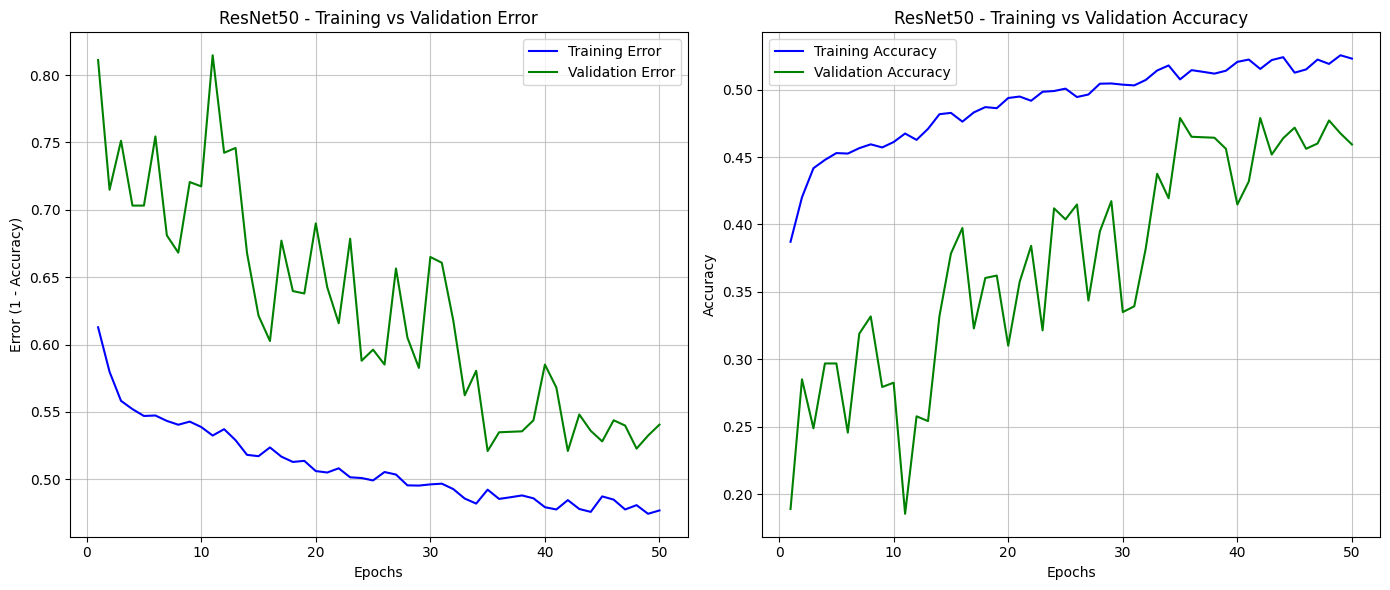

In [70]:
plot_error_accuracy(history, "ResNet50")

changing parameter for early stopping for epoch iteration, increase patience to 20

In [14]:
def train_model(model, train_dataset, validation_dataset, model_name):
    checkpoint_dir = "/kaggle/working" 
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, f"{model_name}_epoch_{{epoch:02d}}.weights.h5"),
        save_weights_only=True,
        save_freq="epoch",
        verbose=1
    )
    # EarlyStopping callback with increased patience
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=20,  # Increased patience, to run more epoch
        restore_best_weights=True
    )
    # Learning Rate Scheduler
    lr_scheduler_cb = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),  # SGD with momentum
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    # Train the model
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=50,
        callbacks=[checkpoint_callback, early_stopping_cb, lr_scheduler_cb]
    )
    return history

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50


I0000 00:00:1734374472.734371      79 service.cc:145] XLA service 0x79e6dc002be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734374472.734468      79 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734374472.734474      79 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/176 ━━━━━━━━━━━━━━━━━━━━ 1:25:11 29s/step - accuracy: 0.2188 - loss: 6.7236

I0000 00:00:1734374486.647046      79 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.3254 - loss: 5.7741
Epoch 1: saving model to /kaggle/working/ResNet101_epoch_01.weights.h5
176/176 ━━━━━━━━━━━━━━━━━━━━ 143s 651ms/step - accuracy: 0.3255 - loss: 5.7705 - val_accuracy: 0.2423 - val_loss: 5.9411 - learning_rate: 0.0100
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.3876 - loss: 3.6105
Epoch 2: saving model to /kaggle/working/ResNet101_epoch_02.weights.h5
176/176 ━━━━━━━━━━━━━━━━━━━━ 85s 470ms/step - accuracy: 0.3877 - loss: 3.6087 - val_accuracy: 0.2377 - val_loss: 3.5831 - learning_rate: 0.0100
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.4045 - loss: 2.5469
Epoch 3: saving model to /kaggle/working/ResNet101_epoch_03.weights.h5
176/176 ━━━━━━━━━━━━━━━━━━━━ 83s 466ms/step - accuracy: 0.4045 - loss: 2.5461 - val_accuracy: 0.2056 - val_loss: 4.2724 - learning_rate: 0.0100
Epoch 4/50
175/176 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.4004 - loss: 2.0439
Epoch 4: savi

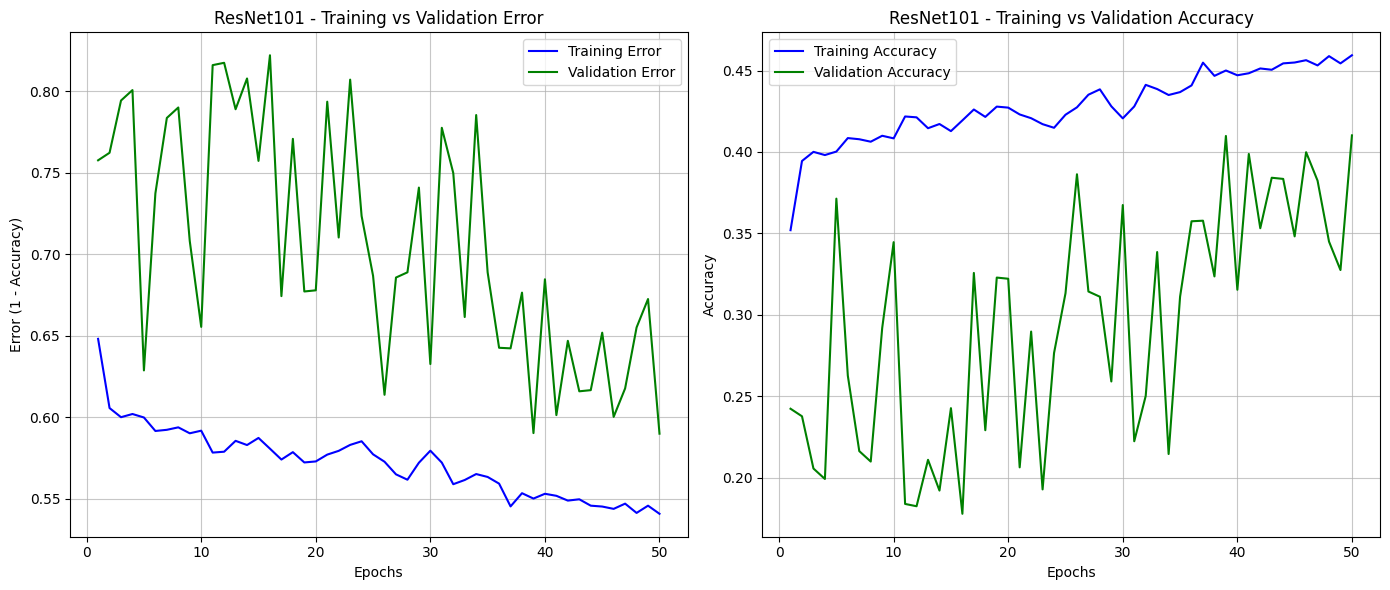

0Times
100Times

--- Evaluating Training Dataset ---
              precision    recall  f1-score   support

           0       0.59      0.09      0.16      1752
           1       0.39      0.88      0.54      1798
           2       0.56      0.13      0.21      1941
           3       0.25      0.18      0.21      2012
           4       0.28      0.73      0.41      1818
           5       0.58      0.07      0.12      1907

    accuracy                           0.34     11228
   macro avg       0.44      0.35      0.27     11228
weighted avg       0.44      0.34      0.27     11228

AUC Score for Training: 0.7891
0Times


In [ ]:
model = build_model("ResNet101")
history = train_model(model, train_dataset, validation_dataset, "ResNet101")
plot_error_accuracy(history, "ResNet101")
evaluate_model(model, train_dataset, "Training")
evaluate_model(model, test_dataset, "Testing")
evaluate_model(model, validation_dataset, "Validating")

Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 139s 615ms/step - accuracy: 0.1695 - loss: 3.9772 - val_accuracy: 0.1650 - val_loss: 1.9837 - learning_rate: 0.0010
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 85s 475ms/step - accuracy: 0.1713 - loss: 1.9499 - val_accuracy: 0.1782 - val_loss: 1.8349 - learning_rate: 0.0010
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 86s 479ms/step - accuracy: 0.1626 - loss: 1.8455 - val_accuracy: 0.1686 - val_loss: 1.8344 - learning_rate: 0.0010
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 86s 481ms/step - accuracy: 0.1794 - loss: 1.8142 - val_accuracy: 0.1782 - val_loss: 1.8126 - learning_rate: 0.0010
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 84s 470ms/step - accuracy: 0.1731 - loss: 1.8028 - val_accuracy: 0.1782 - val_loss: 1.8301 - learning_rate: 0.0010
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 84s 469ms/step - accuracy: 0.1691 - loss: 1.8003 - val_accuracy: 0.1625 - val_loss: 1.8077 - learning_rate: 0.0010
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 85s 477ms/step - accuracy: 0.

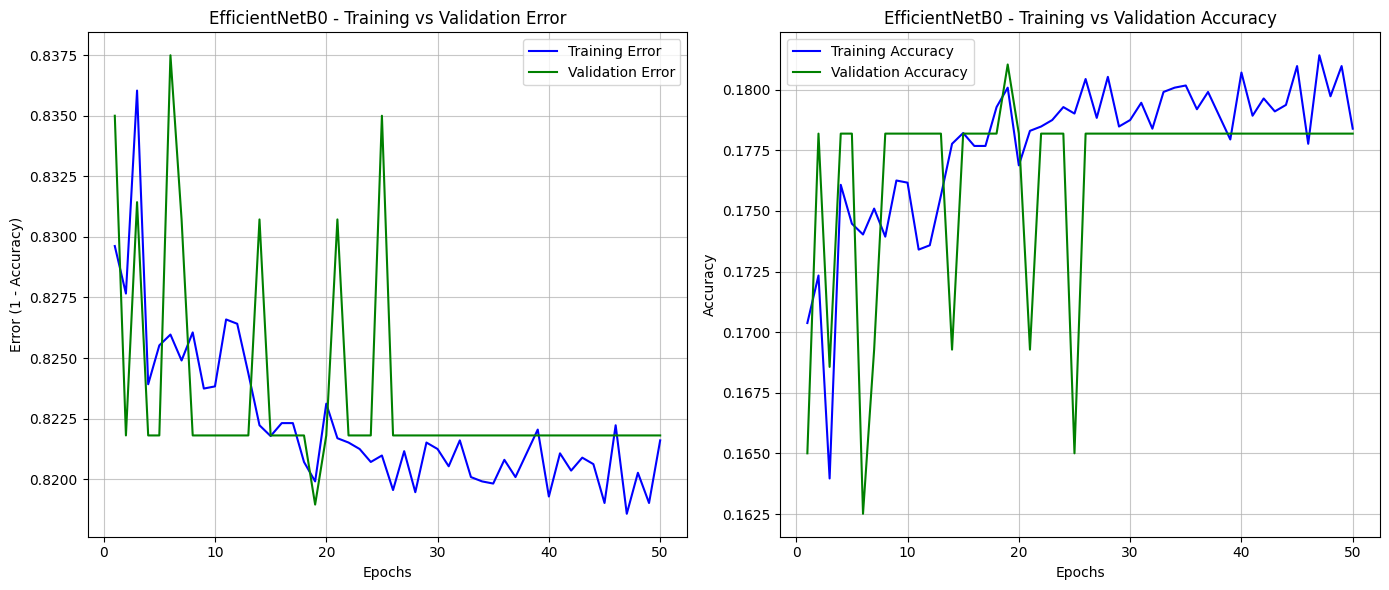

0Times
100Times

--- Evaluating Training Dataset ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1752
           1       0.00      0.00      0.00      1798
           2       0.00      0.00      0.00      1941
           3       0.18      1.00      0.30      2012
           4       0.00      0.00      0.00      1818
           5       0.00      0.00      0.00      1907

    accuracy                           0.18     11228
   macro avg       0.03      0.17      0.05     11228
weighted avg       0.03      0.18      0.05     11228

AUC Score for Training: 0.6182
0Times

--- Evaluating Testing Dataset ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       437
           1       0.00      0.00      0.00       474
           2       0.00      0.00      0.00       553
           3       0.17      1.00      0.30       525
           4       0.00      0.00      0.00       510
     

In [75]:
model = build_model("EfficientNetB0")
history = train_model(model, train_dataset, validation_dataset, "EfficientNetB0")
plot_error_accuracy(history, "EfficientNetB0")
evaluate_model(model, train_dataset, "Training")
evaluate_model(model, test_dataset, "Testing")
evaluate_model(model, validation_dataset, "Validating")

Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 109s 589ms/step - accuracy: 0.6290 - loss: 2.8908 - val_accuracy: 0.5214 - val_loss: 1.7367 - learning_rate: 0.0010
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 102s 571ms/step - accuracy: 0.7294 - loss: 1.1567 - val_accuracy: 0.4850 - val_loss: 1.3888 - learning_rate: 0.0010
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 102s 573ms/step - accuracy: 0.7311 - loss: 0.9400 - val_accuracy: 0.7113 - val_loss: 0.8745 - learning_rate: 0.0010
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 103s 578ms/step - accuracy: 0.7428 - loss: 0.8453 - val_accuracy: 0.6818 - val_loss: 0.9586 - learning_rate: 0.0010
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 102s 571ms/step - accuracy: 0.7408 - loss: 0.8162 - val_accuracy: 0.7153 - val_loss: 0.8144 - learning_rate: 0.0010
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 102s 572ms/step - accuracy: 0.7412 - loss: 0.7875 - val_accuracy: 0.6568 - val_loss: 0.9852 - learning_rate: 0.0010
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 102s 569ms/step - accura

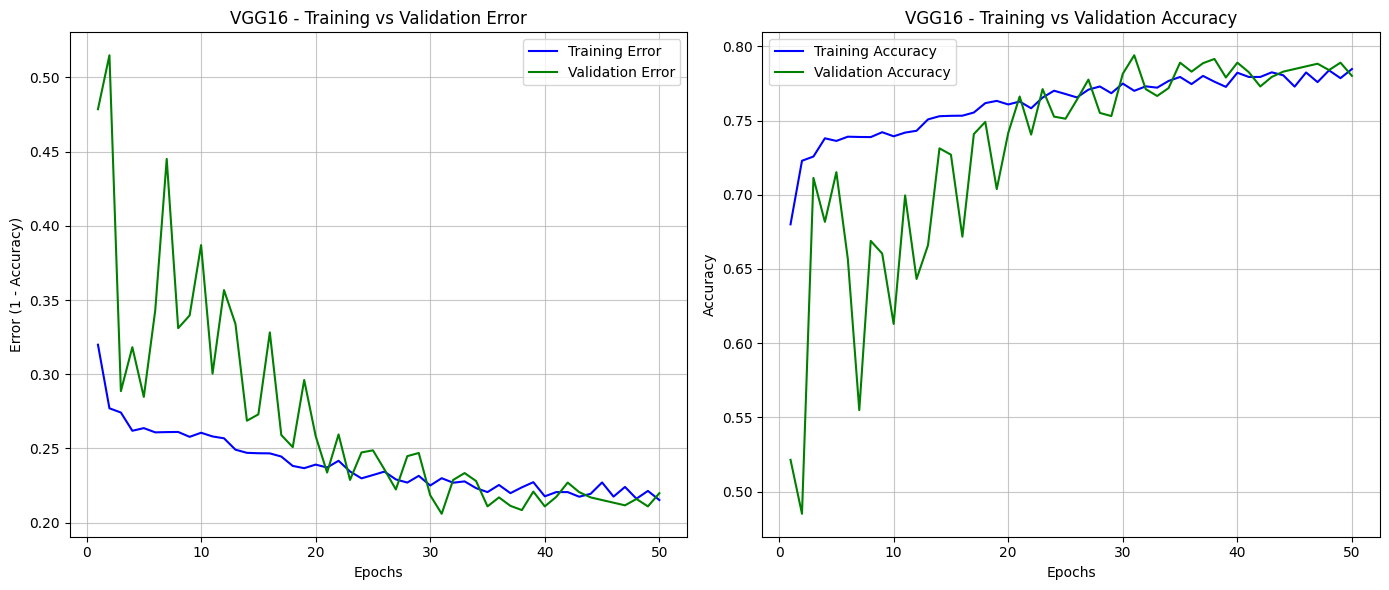

0Times
100Times

--- Evaluating Training Dataset ---
              precision    recall  f1-score   support

           0       0.85      0.71      0.77      1752
           1       0.84      0.97      0.90      1798
           2       0.80      0.67      0.73      1941
           3       0.66      0.83      0.74      2012
           4       0.78      0.70      0.74      1818
           5       0.77      0.78      0.78      1907

    accuracy                           0.78     11228
   macro avg       0.78      0.78      0.78     11228
weighted avg       0.78      0.78      0.77     11228

AUC Score for Training: 0.9617
0Times

--- Evaluating Testing Dataset ---
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       437
           1       0.96      0.92      0.94       474
           2       0.68      0.68      0.68       553
           3       0.72      0.58      0.64       525
           4       0.69      0.86      0.77       510
     

In [74]:
model = build_model("VGG16")
history = train_model(model, train_dataset, validation_dataset, "VGG16")
plot_error_accuracy(history, "VGG16")
evaluate_model(model, train_dataset, "Training")
evaluate_model(model, test_dataset, "Testing")
evaluate_model(model, validation_dataset, "Validating")

It seems that the model "VGG16" clearly outperforms others. As from the first epoch iteration its train accuracy was high and its AUC for test, train, and validation came out to be the highest. 

### Chatgpt prompt/responses

prompt: give me syntax that uses image_dataset_from_directory that splits 20% of train set into validation set and keep 80% as train set

In [ ]:
import tensorflow as tf

# Define paths
train_dir = "../input/test-train/data/seg_train"  # Path to training data
IMG_SIZE = (224, 224)  # Image dimensions
BATCH_SIZE = 64        # Batch size

# Training dataset: 80%
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,    # 20% for validation
    subset="training",       # Specify "training" subset
    seed=123,                # Seed for reproducibility
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Validation dataset: 20%
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,    # 20% for validation
    subset="validation",     # Specify "validation" subset
    seed=123,                # Seed must match the one used for training split
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Print dataset summary
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(validation_dataset))

prompt: give me syntax to train_model() early stop should be in there with penalty of 15 along with learning decay rate, uses this function: def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * float(tf.math.exp(-0.1)), thus it should save weights for every 10 epoch.

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# Learning rate scheduler function
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * float(tf.math.exp(-0.1))  # Exponential decay after 10 epochs

# Train model function
def train_model(model, train_dataset, validation_dataset, model_name, epochs=50):
    # Define callback for learning rate decay
    lr_scheduler_cb = LearningRateScheduler(lr_scheduler, verbose=1)

    # Define early stopping callback
    early_stopping_cb = EarlyStopping(
        monitor="val_loss",
        patience=15,  # Stops training if val_loss doesn't improve for 15 epochs
        restore_best_weights=True
    )

    # Define model checkpoint callback (saves weights every 10 epochs)
    checkpoint_cb = ModelCheckpoint(
        filepath=f"{model_name}_epoch_{{epoch:02d}}.weights.h5",  # Save weights every 10 epochs
        save_weights_only=True,
        save_freq=10 * (len(train_dataset)),  # Save every 10 epochs
        verbose=1
    )

    # Compile the model (ensure optimizer, loss, and metrics are set)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # Initial learning rate
        loss="sparse_categorical_crossentropy",  # Sparse cat

prompt: give me sytax for build_model(), this should use L2 penalty, 20% dropout for model.compile part. thus for model, i want it to select between ResNet50, ResNet101, EfficientNetB0, VGG16

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def build_model(model_name, num_classes, input_shape=(224, 224, 3)):
    """
    Builds a transfer learning model with the option to select ResNet50, ResNet101, EfficientNetB0, or VGG16.
    
    Args:
        model_name (str): Name of the model ("ResNet50", "ResNet101", "EfficientNetB0", "VGG16").
        num_classes (int): Number of classes for the classification task.
        input_shape (tuple): Input shape for the model (default: (224, 224, 3)).
    
    Returns:
        model: A compiled Keras model ready for training.
    """
    # Load pre-trained base model
    if model_name == "ResNet50":
        base_model = tf.keras.applications.ResNet50(
            include_top=False, weights="imagenet", input_shape=input_shape
        )
    elif model_name == "ResNet101":
        base_model = tf.keras.applications.ResNet101(
            include_top=False, weights="imagenet", input_shape=input_shape
        )
    elif model_name == "EfficientNetB0":
        base_model = tf.keras.applications.EfficientNetB0(
            include_top=False, weights="imagenet", input_shape=input_shape
        )
    elif model_name == "VGG16":
        base_model = tf.keras.applications.VGG16(
            include_top=False, weights="imagenet", input_shape=input_shape
        )
    else:
        raise ValueError("Unsupported model name. Choose from: ResNet50, ResNet101, EfficientNetB0, VGG16.")
    
    # Freeze the base model's layers
    base_model.trainable = False

    # Build the custom model
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)  # Pass inputs through the base model
    x = layers.GlobalAveragePooling2D()(x)  # Global average pooling
    x = layers.Dense(
        128, 
        activation="relu", 
        kernel_regularizer=regularizers.l2(0.01)  # L2 regularization
    )(x)
    x = layers.BatchNormalization()(x)       # Batch normalization
    x = layers.Dropout(0.2)(x)               # Dropout with 20% rate
    outputs = layers.Dense(num_classes, activation="softmax")(x)  # Output layer for classification

    # Compile the model
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",  # Use sparse categorical cross-entropy
        metrics=["accuracy"]
    )

    return model